## Understanding NMR Spectroscopy: Chemical Shift & Intensity  

### Chemical Shift (δ)  
- **Chemical shift** tells us how **shielded or deshielded** a nucleus is by electrons.  
- The closer a nucleus is to an **electronegative atom**, the more **deshielded** it becomes, moving **downfield (higher ppm)**.  
- The further it is from electronegative atoms, the more **shielded**, moving **upfield (lower ppm)**.  
- Chemical shift is calculated using:  

  $$
  \delta = \frac{\nu_{\text{sample}} - \nu_{\text{reference}}}{\nu_{\text{reference}}} \times 10^6
  $$

  where:  
  - $ \nu_{\text{sample}} $ = Resonance frequency of the sample.  
  - $ \nu_{\text{reference}} $ = Resonance frequency of a reference compound (e.g., **TMS for $ ^1H $-NMR**).  

### Intensity in NMR  
- **Intensity** represents the number of **nuclei absorbing RF energy** at a given frequency.  
- A peak's intensity is **proportional to the number of equivalent nuclei** in that environment.  
- In **$ ^1H $-NMR**, the **area under the peaks (integration)** reveals **relative proton counts**.  


# Parse and Analyze Data

This is where we get the raw nmr data and get it visualized so that it can be fourier transformed

In [51]:
import pandas as pd
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [52]:
# Try reading the ASCII FID file manually
data = np.genfromtxt(r"c:\Users\Windows User\Documents\JEOL\data\13_03_11_indst_1H fid.asc", delimiter='\t', skip_header=1)

# Create a DataFrame with appropriate column names
df = pd.DataFrame(data, columns=['X', 'Real', 'Imaginary'])

# Display the first few rows of the DataFrame
print(df.head())

name = "JEOL data 13_03_11_indst_1H"

          X      Real  Imaginary
0  0.000000  0.000003   0.000009
1  0.000133 -0.001235  -0.003140
2  0.000267  0.050601   0.188029
3  0.000400  0.019175   0.365893
4  0.000533 -0.136525  -0.611649


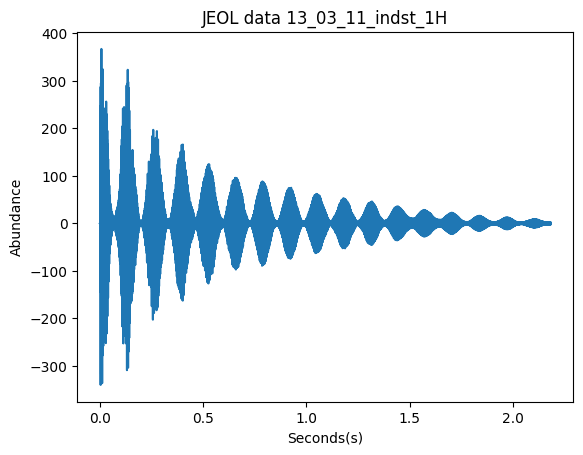

In [53]:
# Ensure data is not None and has valid content
if data is not None and data.size > 0:
	plt.plot(data[:, 0], data[:, 1])  # Assuming the first column is X and the second column is Intensity
	#plt.gca().invert_xaxis()  # Invert x-axis, use after fourier transform
	plt.title(name)
	plt.xlabel("Seconds(s)")
	plt.ylabel("Abundance")
	plt.show()
else:
	print("No valid data found in the file.")


# Fourier Transofrm

Since that the inputted free induction decay (FID) data is a sampled dignal we use the Discrete Fourier Transform. This means using the fft function to get a finite set of frquency components. It is over a finite amount of time (N over a time T, where $N\Delta t = T$). its defined as 

$$\hat{x}(f_n) = \sum_{k=0}^{N-1} x_t e^{-2 \pi i f_n (k \Delta t)} \hspace{10mm} f_n=\frac{n}{N\Delta t}$$

where $f_n$ are the so-called Fourier frequencies. The notation can be simplfied as

When a time series is measured it is discrete and given by $X(t_k)$ where $t_k = k \Delta t$ and $k$ is some integer. If the time series is band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be expressed as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A(f) df$$

where $1/(2\Delta t)$ is the **nyquist frequency** and 

$$\boxed{|A(f)|^2 \equiv S(f)}$$

$S(f)$ is known as the **power spectrum**. It measures the *power* or *amplitude* of a certain frequency present in the continuous time series $X(t)$. If $X(t)$ is real, then $S(f)=S(-f)$, so we only need to consider positive frequencies.


### Note on Nyquist Frequency

If the signal is not band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be written as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A'(f) df$$

where

$$A'(f) = \sum_{k=-\infty}^{\infty} A(f + k/\Delta t) $$

Thus $S'(f) = |A'(f)|^2 \neq S(f)$ and we get power at higher frequencies showing up at lower frequencies. This is known as **aliasing**.

In [54]:
from scipy.fft import fft, fftfreq, fftshift

# Perform Fourier Transform
real_part = data[:, 1]
fft_result = fft(real_part)
frequencies = fftfreq(len(real_part), d=(data[1, 0] - data[0, 0]))  # Calculate frequency axis
fft_magnitude = np.abs(fft_result)

In [55]:
# Keep only the positive half of the spectrum
positive_frequencies = frequencies[frequencies >= 0]
positive_magnitude = fft_magnitude[frequencies >= 0]
# Adjust frequencies by subtracting the x_offset


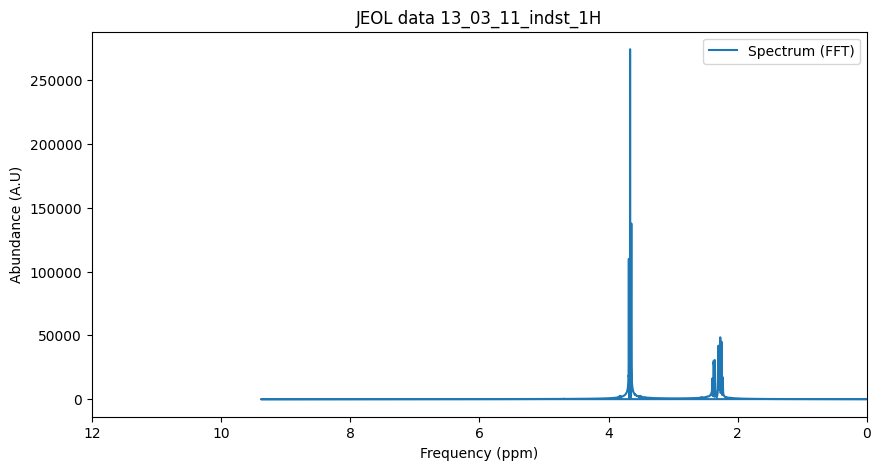

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
plt.gca().invert_xaxis()  # Invert the x-axis
plt.title(name)
plt.xlabel("Frequency (ppm)")
plt.ylabel("Abundance (A.U)")
plt.xlim(12, 0)  # Adjust x-axis limits as needed
plt.legend()
plt.show()

## Creating the threshold for the chemical signals

This part I will be focusing in on identifying an appropiate threshold. It may be done automatically, like "identify the highest peak, the if anything is 85% less intense than that peak then ignore it" type energy.... By nature we will also be zooming in on the spectra

In [57]:
from scipy.signal import find_peaks

def identify_functional_groups(positive_frequencies, positive_magnitudes, ppm_shifts):
    """
    Identify functional groups based on peak positions in the spectrum.
    """
    # Find peaks in the spectrum
    peaks, _ = find_peaks(positive_magnitudes, height=0.1 * max(positive_magnitudes))  # Adjust height threshold as needed
    peak_positions = positive_frequencies[peaks]

    # Map peaks to functional groups
    identified_groups = []
    for peak in peak_positions:
        for group, ppm_range in ppm_shifts.items():
            # Parse the ppm range
            ppm_min, ppm_max = map(float, ppm_range.replace("ppm", "").split("-"))
            if ppm_min <= peak <= ppm_max:
                identified_groups.append((peak, group))
                break

    return identified_groups

# Define the ppm shifts for functional groups
ppm_shifts = {
    "Carboxylic acid": "10-12 ppm",
    "Aldehyde": "9-10 ppm",
    "Benzene ring": "6.5-8.5 ppm",
    "Hydrogen on an alkene": "4.5-6.5 ppm",
    "Benzylic carbons": "2-2.5 ppm",
    "CH2 on a halogen": "2.5-4.5 ppm",
    "Methyl ketone": "2-2.5 ppm",
    "CH": "0.9-1.1 ppm",
    "CH2": "1.1-1.4 ppm",
    "CH3": "1.4-1.7 ppm"
}

# Identify functional groups based on the spectrum
identified_groups = identify_functional_groups(
    fftshift(positive_frequencies) / 399.5,  # Convert frequencies to ppm
    fftshift(positive_magnitude),
    ppm_shifts
)

# Print the identified functional groups
if identified_groups:
    print("Identified functional groups:")
    for peak, group in identified_groups:
        print(f"The Peak at {peak:.2f} ppm corresponds to a {group}")
else:
    print("No functional groups identified.")

Identified functional groups:
The Peak at 2.25 ppm corresponds to a Benzylic carbons
The Peak at 2.27 ppm corresponds to a Benzylic carbons
The Peak at 2.28 ppm corresponds to a Benzylic carbons
The Peak at 2.28 ppm corresponds to a Benzylic carbons
The Peak at 2.30 ppm corresponds to a Benzylic carbons
The Peak at 2.30 ppm corresponds to a Benzylic carbons
The Peak at 2.36 ppm corresponds to a Benzylic carbons
The Peak at 2.37 ppm corresponds to a Benzylic carbons
The Peak at 2.38 ppm corresponds to a Benzylic carbons
The Peak at 3.65 ppm corresponds to a CH2 on a halogen
The Peak at 3.67 ppm corresponds to a CH2 on a halogen
The Peak at 3.69 ppm corresponds to a CH2 on a halogen


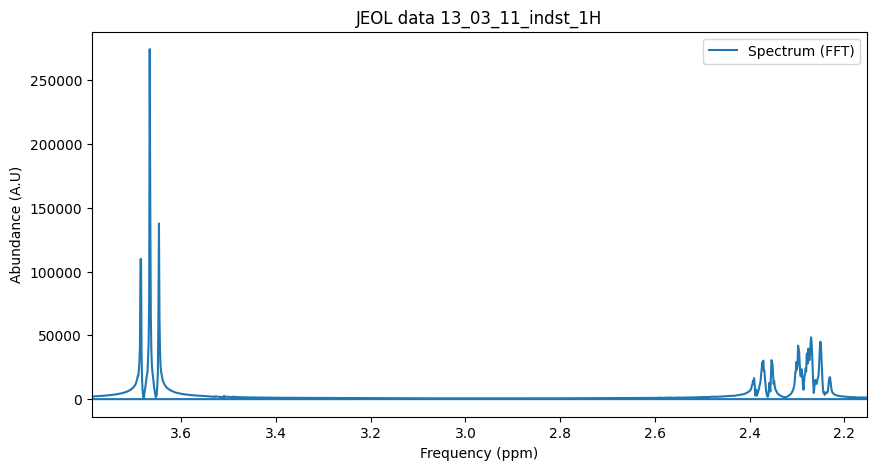

Graph automatically zoomed to range: 2.15 ppm to 3.79 ppm


In [58]:
# Automatically adjust the graph limits based on identified functional groups
if identified_groups:
    # Extract the ppm values of the identified peaks
    peak_ppms = [peak for peak, _ in identified_groups]
    x_min = min(peak_ppms) - 0.1  # Add a small buffer for better visualization
    x_max = max(peak_ppms) + 0.1

    # Plot the spectrum with adjusted x-axis limits
    plt.figure(figsize=(10, 5))
    plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
    plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(x_max, x_min)  # Set x-axis limits based on identified peaks
    plt.legend()
    plt.show()

    print(f"Graph automatically zoomed to range: {x_min:.2f} ppm to {x_max:.2f} ppm")
else:
    print("No functional groups identified. Default graph will be displayed.")
    # Default graph
    plt.figure(figsize=(10, 5))
    plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
    plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(x_max, x_min)  # Set x-axis limits based on identified peaks
    plt.legend()
    plt.show()

In [59]:
# Set a threshold for peak detection based on abundance (A.U.)
# You can adjust 'height_threshold' to filter out noise and insignificant peaks
height_threshold = 0.1 * max(positive_magnitude)  # Example: 20% of max intensity

# Optionally, set minimum distance and prominence between peaks
min_distance = 100  # Adjust as needed (in data points)
min_prominence = 0.05 * max(positive_magnitude)  # Example: 10% of max intensity

# Find peaks using the specified thresholds
peaks, properties = find_peaks(
    positive_magnitude,
    height=height_threshold,
    distance=min_distance,
    prominence=min_prominence
)

# Print the detected peaks and their properties
#print(f"Number of significant peaks found: {len(peaks)}")
###  print(f"Peak at {peak_ppm:.2f} ppm with height {positive_magnitude[idx]:.2f}")

# You can now use these filtered peaks for further analysis or plotting


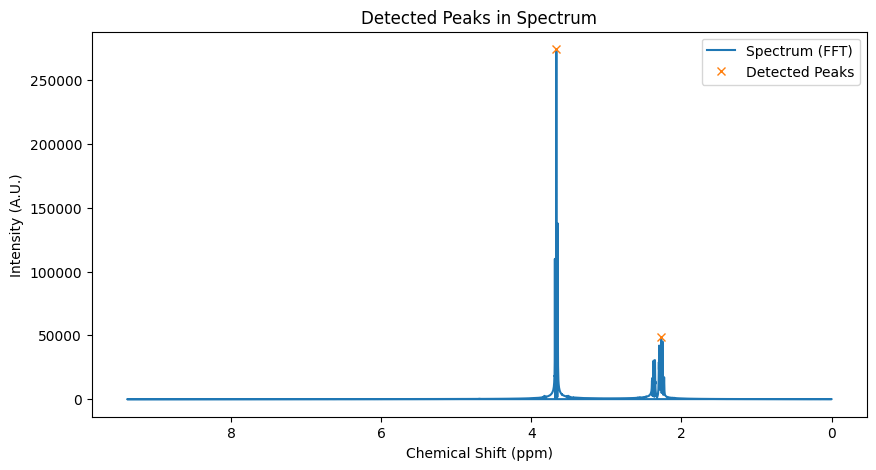

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(positive_frequencies) / 399.78219838, fftshift(positive_magnitude), label="Spectrum (FFT)")
plt.plot(fftshift(positive_frequencies[peaks]) / 399.78219838, fftshift(positive_magnitude[peaks]), "x", label="Detected Peaks")
plt.gca().invert_xaxis()  # Invert the x-axis
plt.xlabel("Chemical Shift (ppm)")
plt.ylabel("Intensity (A.U.)")
plt.title("Detected Peaks in Spectrum")
plt.legend()
plt.show()

In [61]:
# Parameters
ppm_range = 12  # Your spectra goes from 0 to 12 ppm
spectrometer_freq = 399.78219838  # MHz
n_points = len(positive_magnitude)

# Resolution conversions
hz_per_point = (ppm_range * spectrometer_freq) / n_points
ppm_per_point = ppm_range / n_points

# Choose min distance in Hz (e.g., 7 Hz for typical J-coupling separation)
min_distance_hz = 7
min_distance = int(min_distance_hz / hz_per_point)

# Thresholds
height_threshold = 0.1 * max(positive_magnitude)
min_prominence = 0.05 * max(positive_magnitude)

# Detect peaks
peaks, properties = find_peaks(
    positive_magnitude,
    height=height_threshold,
    distance=min_distance,
    prominence=min_prominence
)

# Convert indices to ppm
peak_ppms = [i * ppm_per_point for i in peaks]
for idx, ppm in zip(peaks, peak_ppms):
    print(f"Peak at {ppm:.2f} ppm with height {positive_magnitude[idx]:.2f}")


Peak at 2.88 ppm with height 45034.89
Peak at 2.90 ppm with height 48471.76
Peak at 2.94 ppm with height 42000.17
Peak at 3.01 ppm with height 30650.04
Peak at 3.03 ppm with height 30232.82
Peak at 4.66 ppm with height 137644.17
Peak at 4.69 ppm with height 274129.02
Peak at 4.71 ppm with height 109922.51


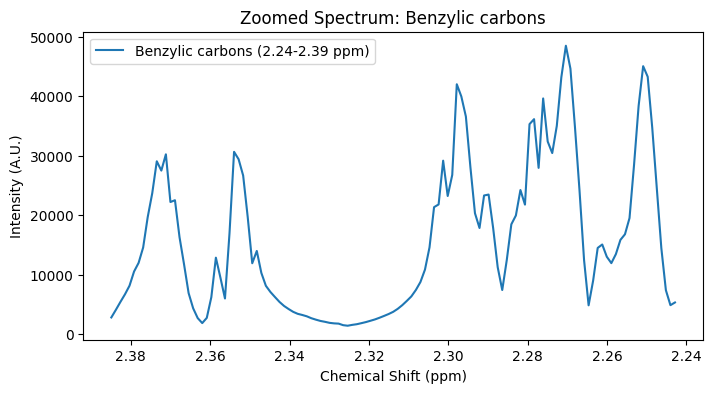

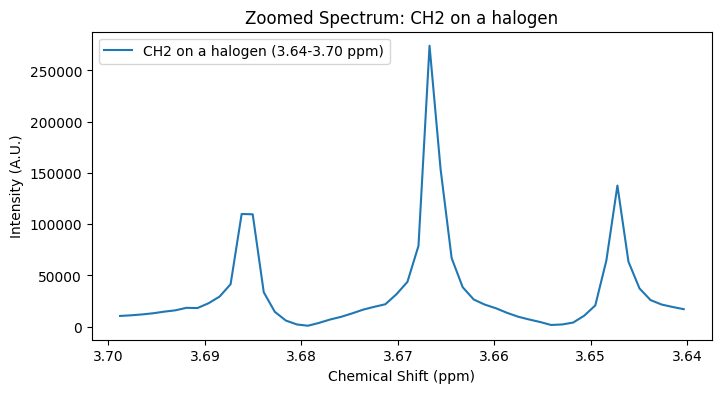

In [62]:
def auto_zoom_functional_groups(positive_frequencies, positive_magnitude, identified_groups, ppm_shifts, buffer=0.01):
    """
    For each functional group with detected peaks, plot a zoomed-in graph
    covering the range from the lowest to highest detected peak in that group,
    with a buffer added to both sides.
    """
    # Group peaks by functional group
    group_peaks = {}
    for peak_ppm, group in identified_groups:
        group_peaks.setdefault(group, []).append(peak_ppm)

    for group, peaks in group_peaks.items():
        ppm_range_str = ppm_shifts.get(group)
        if not ppm_range_str:
            continue
        ppm_min, ppm_max = map(float, ppm_range_str.replace("ppm", "").split("-"))
        # Only consider peaks within the defined ppm range for the group
        peaks_in_range = [ppm for ppm in peaks if ppm_min <= ppm <= ppm_max]
        if not peaks_in_range:
            continue
        # Define zoom window: min and max peak in group ± buffer
        zoom_min = min(peaks_in_range) - buffer
        zoom_max = max(peaks_in_range) + buffer
        # Mask for the zoomed region
        ppm_axis = positive_frequencies / 399.78219838
        mask = (ppm_axis >= zoom_min) & (ppm_axis <= zoom_max)
        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(ppm_axis[mask], positive_magnitude[mask], label=f"{group} ({zoom_min:.2f}-{zoom_max:.2f} ppm)")
        plt.gca().invert_xaxis()
        plt.title(f"Zoomed Spectrum: {group}")
        plt.xlabel("Chemical Shift (ppm)")
        plt.ylabel("Intensity (A.U.)")
        plt.legend()
        plt.show()

auto_zoom_functional_groups(
    fftshift(positive_frequencies),
    fftshift(positive_magnitude),
    identified_groups,
    ppm_shifts,
    buffer=0.01
)

# Peak Integration

### What is Peak Integration?
- **Peak integration** measures the **area under an NMR signal peak**, which corresponds to the **relative number of nuclei** producing that signal.
- This area is proportional to the **number of equivalent protons** (or other nuclei) in that chemical environment.
- Integration allows us to determine **relative ratios** of different types of protons in a molecule, which is key for structure elucidation.

### Mathematical Definition
- Given a peak represented by a function $f(\delta)$, where $f(\delta)$ is the intensity at chemical shift $\delta$ (in ppm), the **integrated area** $A$ over the peak range $[a, b]$ is:

  $$
  A = \int_{a}^{b} f(\delta) \, d\delta
  $$

- In practice, the spectrum is **digitized** at discrete points $\{ \delta_i, f_i \}$, so the integral is approximated numerically, often using **Simpson's rule** or the **trapezoidal rule**:

  $$
  A \approx \sum_{i=m}^{n} f_i \, \Delta \delta_i
  $$

  where $m$ and $n$ are the indices corresponding to the integration limits $a$ and $b$, and $\Delta \delta_i = \delta_{i+1} - \delta_i$.

### Why Use Numerical Integration?
- NMR data consists of discrete intensity values at sampled chemical shifts, not a continuous function.
- Numerical integration accounts for **peak shapes and widths**, capturing total area more accurately than just peak height.

### Relative Integration and Normalization
- Since the absolute areas depend on instrument sensitivity and sample concentration, we often use **relative integration** by normalizing all peak areas to the smallest peak area:

  $$
  A_{\text{relative}, i} = \frac{A_i}{\min_j A_j}
  $$

- These relative integrals are then **rounded** to assign integer values corresponding to the number of nuclei (e.g., 1, 2, 3 protons).

---

This integration process connects raw NMR intensity data to meaningful chemical information about the number and environment of nuclei, bridging experimental data with molecular structure.

In [64]:
from scipy.integrate import simpson as simps

# Integrate each detected peak using its left and right bases from the 'properties' dictionary

integrated_areas = []
for i, peak_idx in enumerate(peaks):
    left = properties['left_bases'][i]
    right = properties['right_bases'][i]
    # Extract the region for integration
    freq_region = positive_frequencies[left:right+1]
    mag_region = positive_magnitude[left:right+1]
    # Integrate using Simpson's rule
    area = simps(mag_region, freq_region)
    integrated_areas.append(area)

# Print the integrated area for each peak
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    print(f"Peak at {peak_ppm:.2f} ppm: Integrated area = {integrated_areas[i]:.2f}")

Peak at 2.25 ppm: Integrated area = 455020.82
Peak at 2.27 ppm: Integrated area = 1519835.17
Peak at 2.30 ppm: Integrated area = 812636.39
Peak at 2.35 ppm: Integrated area = 594888.16
Peak at 2.37 ppm: Integrated area = 473637.27
Peak at 3.65 ppm: Integrated area = 2118553.53
Peak at 3.67 ppm: Integrated area = 3268420.34
Peak at 3.69 ppm: Integrated area = 764856.29


In [65]:
# Precompute peak data: (ppm, area)
peak_data = []
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    area = integrated_areas[i]
    peak_data.append((peak_ppm, area))


Now that we have the integration the numbers are numerically okay but they aren't to scale of our 1H nmr

In [66]:
# Normalize to smallest peak (assuming it's not noise)
min_area = min(integrated_areas)
normalized_integrals = [area / min_area for area in integrated_areas]

# Optionally round to nearest half or whole number
rounded_integrals = [round(val, 1) for val in normalized_integrals]

# Print with normalized integration values
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    print(f"Peak at {peak_ppm:.2f} ppm: Relative integration = {rounded_integrals[i]}")

Peak at 2.25 ppm: Relative integration = 1.0
Peak at 2.27 ppm: Relative integration = 3.3
Peak at 2.30 ppm: Relative integration = 1.8
Peak at 2.35 ppm: Relative integration = 1.3
Peak at 2.37 ppm: Relative integration = 1.0
Peak at 3.65 ppm: Relative integration = 4.7
Peak at 3.67 ppm: Relative integration = 7.2
Peak at 3.69 ppm: Relative integration = 1.7


In [67]:
def smart_round(val, threshold=0.0001):
    lower = int(val)
    upper = lower + 1
    if val - lower < 0.5 - threshold:
        return lower
    elif val - lower > 0.5 + threshold:
        return upper
    else:
        return round(val)  # round normally if within the threshold window

In [68]:
# Normalize by the smallest non-zero area
min_area = min(integrated_areas)
relative_integrals = [area / min_area for area in integrated_areas]

# Round them if desired (e.g. to 1 decimal place or to nearest integer)
rounded_integrals = [smart_round(val, 0.001) for val in relative_integrals]

# Build peak_data using the normalized values
peak_data = [
    (positive_frequencies[peak_idx] / spectrometer_freq, rounded_integrals[i])
    for i, peak_idx in enumerate(peaks)
]

# Print the relative integration for each peak
for i, peak_idx in enumerate(peaks):
    peak_ppm = positive_frequencies[peak_idx] / spectrometer_freq
    print(f"Peak at {peak_ppm:.2f} ppm: Relative integration = {rounded_integrals[i]}")

Peak at 2.25 ppm: Relative integration = 1
Peak at 2.27 ppm: Relative integration = 3
Peak at 2.30 ppm: Relative integration = 2
Peak at 2.35 ppm: Relative integration = 1
Peak at 2.37 ppm: Relative integration = 1
Peak at 3.65 ppm: Relative integration = 5
Peak at 3.67 ppm: Relative integration = 7
Peak at 3.69 ppm: Relative integration = 2


Now that we have the integration we can combine the integration and the functional group analysis together

In [69]:
def auto_zoom_functional_groups_with_integration(positive_frequencies, positive_magnitude, identified_groups, ppm_shifts, peak_data, buffer=0.01):
    """
    For each functional group with detected peaks, plot a zoomed-in graph
    including integrated peak annotations.
    """
    # Group peaks by functional group
    group_peaks = {}
    for peak_ppm, group in identified_groups:
        group_peaks.setdefault(group, []).append(peak_ppm)

    for group, peaks in group_peaks.items():
        ppm_range_str = ppm_shifts.get(group)
        if not ppm_range_str:
            continue
        ppm_min, ppm_max = map(float, ppm_range_str.replace("ppm", "").split("-"))
        # Only consider peaks within the defined ppm range for the group
        peaks_in_range = [ppm for ppm in peaks if ppm_min <= ppm <= ppm_max]
        if not peaks_in_range:
            continue

        # Define zoom window
        zoom_min = min(peaks_in_range) - buffer
        zoom_max = max(peaks_in_range) + buffer

        # Create ppm axis
        ppm_axis = positive_frequencies / 399.78219838
        mask = (ppm_axis >= zoom_min) & (ppm_axis <= zoom_max)

        # Plot spectrum
        plt.figure(figsize=(8, 4))
        plt.plot(ppm_axis[mask], positive_magnitude[mask], label=f"{group} ({zoom_min:.2f}-{zoom_max:.2f} ppm)")

        # Annotate integrated peaks within this region
        for ppm, area in peak_data:
            if zoom_min <= ppm <= zoom_max:
                plt.axvline(ppm, color='black', linestyle='--', linewidth=1)
                # Offset the text slightly to the right of the line
                plt.text(
                    ppm + 0.01,  # shift right by 0.01 ppm
                    max(positive_magnitude[mask]) * 0.9,
                    f"{area:.2f}",
                    rotation=0,  # horizontal text
                    va='center',
                    ha='left',
                    fontsize=9,
                    color='black',
                    fontweight='bold'
                )

        plt.gca().invert_xaxis()
        plt.title(f"Zoomed Spectrum: {group}")
        plt.xlabel("Chemical Shift (ppm)")
        plt.ylabel("Intensity (A.U.)")
        plt.legend()
        plt.tight_layout()
        plt.show()

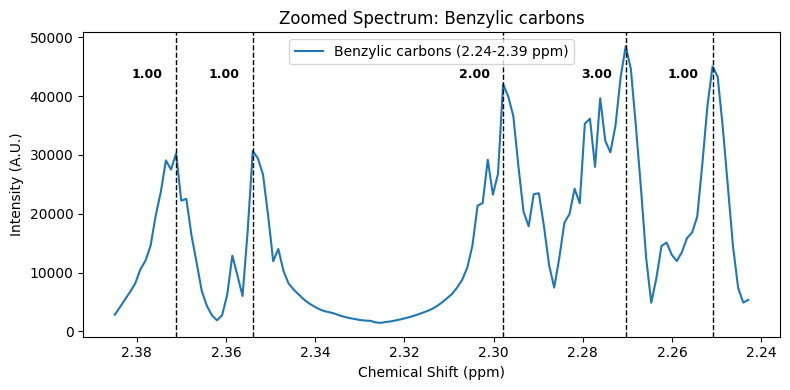

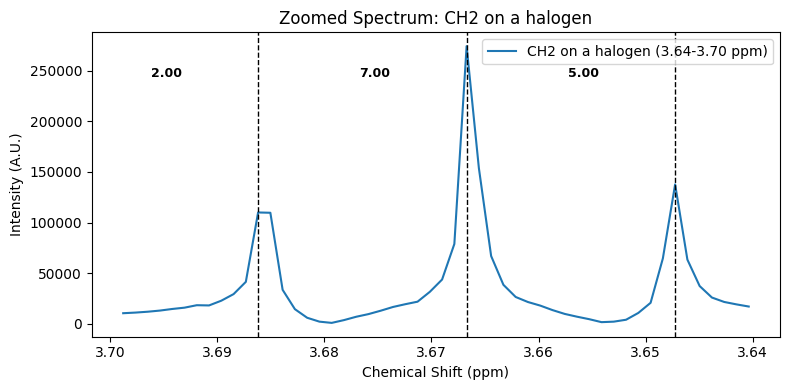

In [70]:
auto_zoom_functional_groups_with_integration(
    fftshift(positive_frequencies),
    fftshift(positive_magnitude),
    identified_groups,
    ppm_shifts,
    peak_data,
    buffer=0.01
)

# Spin-Spin Coupling

In [71]:
# Example: Convert ppm difference to Hz
def ppm_to_hz(ppm_diff, spectrometer_freq):
    return ppm_diff * spectrometer_freq

def detect_multiplet(ppm_axis, intensity, center_ppm, window=0.05):
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    sub_peaks, _ = find_peaks(intensity[mask], height=0.1 * max(intensity[mask]))
    sub_ppms = ppm_axis[mask][sub_peaks]
    return sub_ppms

def estimate_j_coupling(sub_ppms, spectrometer_freq):
    sub_ppms = sorted(sub_ppms)
    j_values = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i-1])
        j_values.append(ppm_to_hz(ppm_diff, spectrometer_freq))
    return j_values

def estimate_j_couplings_from_multiplet(ppm_axis, intensity, center_ppm, spectrometer_freq, window=0.05):
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    sub_peaks, _ = find_peaks(intensity[mask], height=0.1 * max(intensity[mask]))
    sub_ppms = ppm_axis[mask][sub_peaks]
    
    # Sort and compute J values
    sub_ppms = np.sort(sub_ppms)
    j_couplings = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i - 1])
        j_hz = ppm_to_hz(ppm_diff, spectrometer_freq)
        j_couplings.append(j_hz)
    
    return sub_ppms, j_couplings

Keep

In [103]:
def detect_and_plot_multiplet(
    ppm_axis, intensity, center_ppm, spectrometer_freq, window=0.025,
    integration_lookup=None, group_name=None
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    from scipy.ndimage import gaussian_filter1d

    # Mask for the region of interest
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    region_ppm = ppm_axis[mask]
    region_intensity = intensity[mask]

    # Smooth the intensity to reduce noise
    region_intensity = gaussian_filter1d(region_intensity, sigma=2)

    # Find sub-peaks in the region with stricter thresholds
    sub_peaks, _ = find_peaks(
        region_intensity,
        height=0.2 * max(region_intensity),
        prominence=0.1 * max(region_intensity)
    )
    sub_ppms = region_ppm[sub_peaks]

    # Sort sub-peaks and estimate J-couplings
    sub_ppms = np.sort(sub_ppms)
    j_couplings = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i - 1])
        j_hz = ppm_diff * spectrometer_freq
        j_couplings.append(j_hz)

    # Plot the multiplet region
    # ...existing code...

    # Plot the multiplet region
    plt.figure(figsize=(8, 4))
    label = f"{group_name} ({min(region_ppm):.2f}-{max(region_ppm):.2f} ppm)" if group_name else None
    plt.plot(region_ppm, region_intensity, label=label)

    # Annotate sub-peaks with integration values
    for i, ppm in enumerate(sub_ppms):
        plt.axvline(ppm, color='black', linestyle='--', linewidth=1)
        integration_val = None
        if integration_lookup is not None:
            closest = min(integration_lookup, key=lambda x: abs(x[0] - ppm))
            if abs(closest[0] - ppm) < 0.02:
                integration_val = closest[1]
        y_val = region_intensity[sub_peaks[i]] * 0.95
        if integration_val is not None:
            plt.text(
                ppm + 0.01,
                y_val,
                f"{integration_val:.2f}",
                rotation=0,
                va='center',
                ha='left',
                fontsize=8,
                color='black',
                fontweight='bold'
            )

    # Annotate J values between peaks (at midpoint)
    for i in range(1, len(sub_ppms)):
        mid_ppm = (sub_ppms[i] + sub_ppms[i-1]) / 2
        y_mid = max(region_intensity) * 0.8
        j_hz = (sub_ppms[i] - sub_ppms[i-1]) * spectrometer_freq
        plt.text(
            mid_ppm, y_mid,
            f"J = {j_hz:.3f} Hz",
            ha='center', va='bottom', fontsize=7.5, color='red', fontweight='bold'
        )
        # Optionally, draw a bracket or line between peaks
        plt.plot([sub_ppms[i-1], sub_ppms[i]], [y_mid*0.98, y_mid*0.98], color='red', linewidth=1)

    plt.gca().invert_xaxis()
    plt.title(f"Zoomed Spectrum: {group_name or f'Multiplet near {center_ppm:.2f} ppm'}")
    plt.xlabel("Chemical Shift (ppm)")
    plt.ylabel("Intensity (A.U.)")
    if label:
        plt.legend()
    plt.tight_layout()
    plt.show()
# ...existing code...

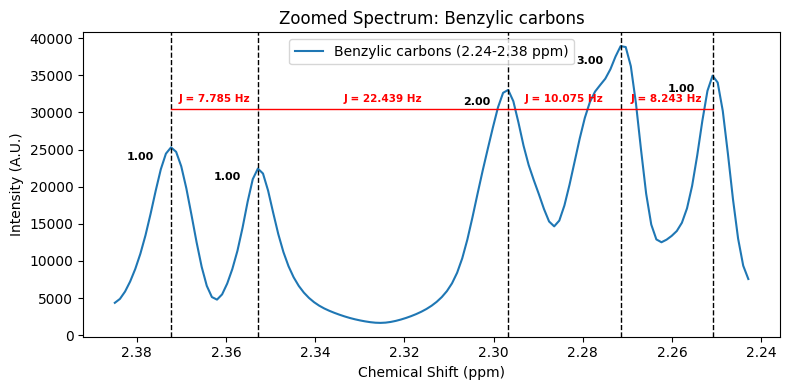

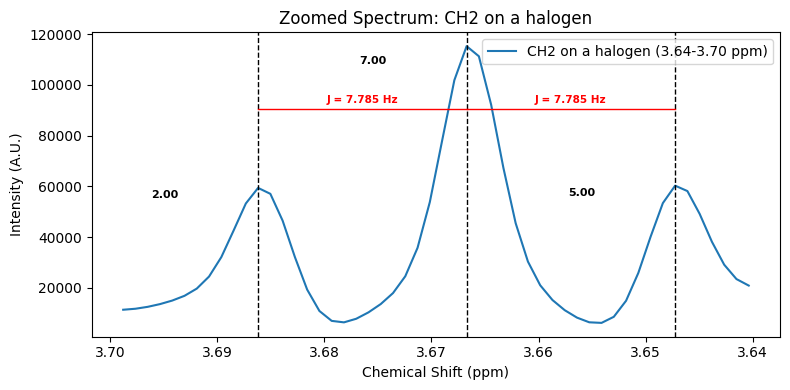

In [104]:
buffer = 0.01  # or match the buffer you use in your zoomed spectrum

for group_name in unique_groups:
    group_peaks = [ppm for ppm, grp in identified_groups if grp == group_name]
    if group_peaks:
        zoom_min = min(group_peaks) - buffer
        zoom_max = max(group_peaks) + buffer
        center_ppm = (zoom_min + zoom_max) / 2
        window = (zoom_max - zoom_min) / 2
        detect_and_plot_multiplet(
            ppm_axis, intensity, center_ppm, spectrometer_freq, window=window,
            integration_lookup=peak_data,
            group_name=group_name
        )